In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sdeint

### Variable Descriptions Used in Dynamical Model

Variable|Description
:---|:---
V|Viral load per epithelial cell
H|Proportion of healthy cells
I|Proportion of infected cells 
M|Activated antigen presenting cells per homeostatic level
F|Interferons per homeostatic level of macrophages
R|Proportion of resistant cells
E|Effector cells per homeostatic level 
P|Plasma cells per homeostatic level
A|Antibodies per homeostatic level 
S|Antigenic distance

<br />

### Parameter Descriptions and Values for Differential Equations

Parameter|Value|Description
:---|:---:|:---
$\gamma_{V}$|510|Rate constant of influenza A virus (IAV) particles secretion per infected epithelial cells
$\gamma_{VA}$|619.2|Rate constant of neutralization of IAV by antibodies
$\gamma_{VH}$|1.02|Rate constant of adsorption of IAV by infected epithelial cells
$alpha_{V}$|1.7|Rate constant of nonspecific IAV removal
$a_{V1}$|100|Rate constant of nonspecific IAV removal
$a_{V2}$|23000|Rate constant of nonspecific IAV removal
$b_{HD}$|4|Rate constant of regeneration of epithelial cells
$a_{R}$|1|Rate constant of epithelial cells’ virus resistance state decay
$\gamma_{HV}$|0.34|Rate constant of epithelial cells infected by IAV
$b_{HF}$|0.01|Rate constant of epithelial cells’ virus resistant state induction
$b_{IE}$|0.066|Rate constant of infected epithelial cells that CTL damage
$a_{I}$|1.5|Rate constant of infected epithelial cells damage by cytopathicity of IAV
$b_{MD}$|1|Rate constant of stimulation of antigen presenting cells by dead cells
$b_{MV}$|0.0037|Rate constant of stimulation of antigen presenting cells by virus particles
$a_{M}$|1|Rate constant of stimulated state loss of antigen presenting cells
$b_{F}$|250000|Interferon (IFN) production rate per APC
$c_{F}$|2000|Interferon (IFN) production rate per infected cell
$b_{FH}$|17|Rate constant of epithelial cells that IFN binds
$a_{F}$|8|Rate constant of IFN’s natural decay
$b_{EM}$|8.8|Rate constant of stimulation of effector cells
$b_{EI}$|2.72|Rate constant of death of effectors by lytic interactions with infected epithelial cells
$a_{E}$|0.4|Rate constant of natural death of effector cells
$b_{PM}$|11.5|Rate constant of plasma cells production
$a_{P}$|0.4|Rate constant of natural death of plasma cells
$b_{A}$|0.043|Antibody production rate per plasma cells 
$\gamma_{AV}$|146.2|Rate constant of antibodies which binds to IAV
$a_{A}$|0.043|Rate constant of natural death of antibodies
$r$|3e-5|Rate constant for S variable

In [8]:
# Define system of equations
def deriv_std(state, t, params):
    '''
    Computes the derivatives of a dynamical model of human immune response to influenza A virus infection.

    Parameters:
        state (array_like): An array-like object of length 10 representing the state of the system at time t.

        t (float): The current time point

        params (list): A list containing the values of the parameters in the system of differential equations.

    Returns:
        array_like: An array of length 10 representing the derivatives of the state variables with respect to time.
            The elements of the array correspond to the elements of the state array in the same order.
    '''
    
    # Unpack parameters
    gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r = params
    
    # Unpack state variables
    V, H, I, M, F, R, E, P, A, S = state

    # Define proportion of dead cells
    D = 1 - H - R - I

    # Define differential equations
    dVdt = (gammaV * I) - (gammaVA * S * A * V) - (gammaVH * H * V) - (alphaV * V) - ((aV1 * V)/(1 + (aV2 * V)))
    dHdt = ((bHD * D) * (H + R)) + (aR * R) - (gammaHV * V * H) - (bHF * F * H)
    dIdt = (gammaHV * V * H) - (bIE * E * I) - (aI * I)
    dMdt = (((bMD * D) + (bMV * V)) * (1 - M)) - (aM * M)
    dFdt = (bF * M) + (cF * I) - (bFH * H * F) - (aF * F)
    dRdt = (bHF * F * H) - (aR * R)
    dEdt = (bEM * M * E) - (bEI * I * E) + (aE * (1 - E))
    dPdt = (bPM * M * P) + (aP * (1 - P))
    dAdt = (bA * P) - (gammaAV * S * A * V) - (aA * A)
    dSdt = (r * P) * (1 - S)

    # Return an array containing the derivative of each variable
    return np.array([dVdt, dHdt, dIdt, dMdt, dFdt, dRdt, dEdt, dPdt, dAdt, dSdt])


In [6]:
# Define standard parameters
gammaV = 510
gammaVA = 619.2
gammaVH = 1.02
alphaV = 1.7
aV1 = 100
aV2 = 23000
bHD = 4
aR = 1
gammaHV = 0.34
bHF = 0.01
bIE = 0.066
aI = 1.5
bMD = 1
bMV = 0.0037
aM = 1
bF = 250000
cF = 2000
bFH = 17
aF = 8
bEM = 8.8
bEI = 2.72
aE = 0.4
bPM = 11.5
aP = 0.4
bA = 0.043
gammaAV = 146.2
aA = 0.043
r = 3e-5

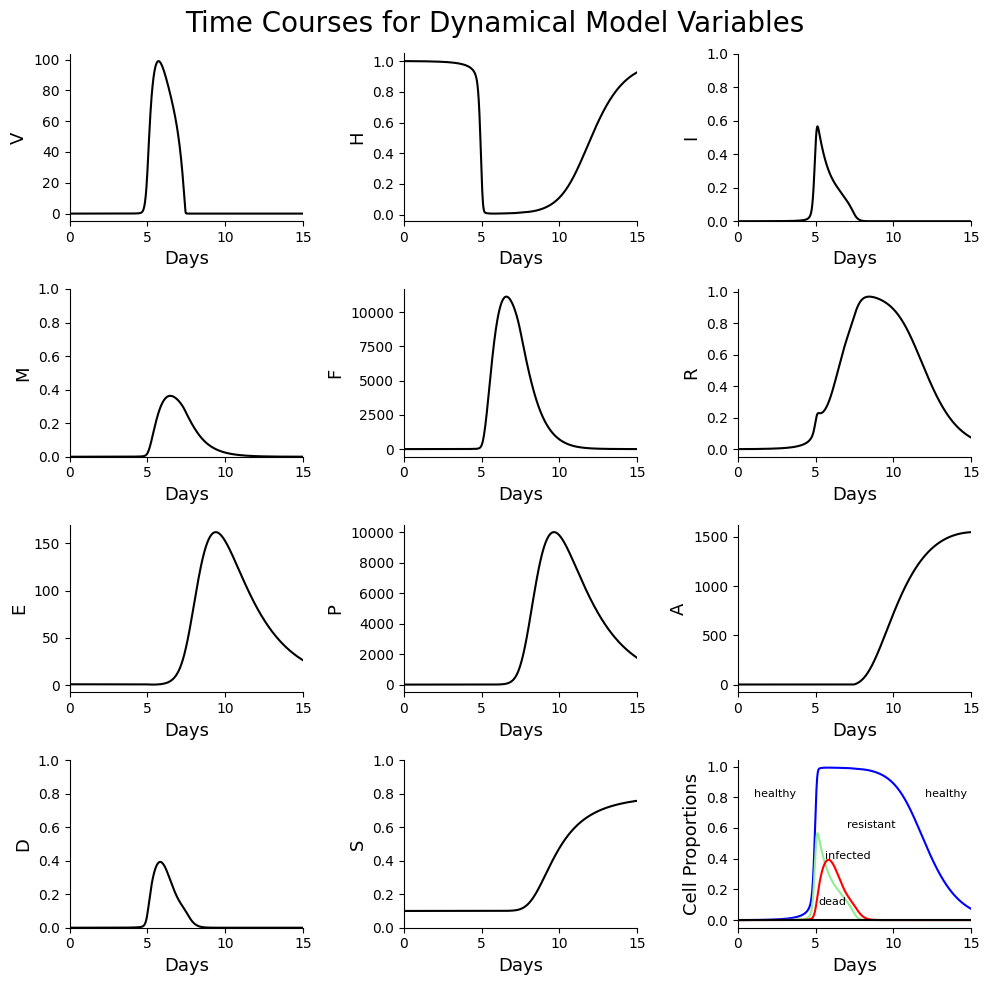

In [62]:
# Figure 1

# Generate time array that contains 1000 equally-spaced values between 0 and 15
t = np.linspace(0, 15, 1000)

# Define parameters under standard conditions
params_std = [gammaV, gammaVA, gammaVH, alphaV, aV1, aV2, bHD, aR, gammaHV, bHF, bIE, aI, bMD, bMV, aM, bF, cF, bFH, aF, bEM, bEI, aE, bPM, aP, bA, gammaAV, aA, r]

# Define initial values for standard behavior
V0, H0, I0, M0, F0, R0, E0, P0, A0, S0 = 0.01, 1, 0, 0, 0, 0, 1, 1, 1, 0.1

# Initial state of the system
state0 = [V0, H0, I0, M0, F0, R0, E0, P0, A0, S0]

# Integrate the system of differential equations over time t
state = odeint(deriv_std, state0, t, args=(params_std,))

# Transpose state matrix to get individual time series for each variable
V, H, I, M, F, R, E, P, A, S = state.T

# Define proportion of dead cells
D = 1 - H - R - I

# Initialize subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5, 10))
fig.set_figwidth(10)
fig.suptitle('Time Courses for Dynamical Model Variables', fontsize = 20)
fig.subplots_adjust(top=0.94)

# Initialize values and labels
x_labels = ['V', 'H', 'I', 'M', 'F', 'R', 'E', 'P', 'A', 'D', 'S', 'Cell Proportions']
y_vals = [V, H, I, M, F, R, E, P, A, D, S]

# Iterate through subplots, plotting each timecourse
for i, ax in enumerate(axes.flat):
    ax.set_xlim(0, 15)
    ax.set_xlabel('Days', fontsize=13)
    ax.set_ylabel(x_labels[i], fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if i in range(0, 11):
        ax.plot(t, y_vals[i], color = 'k')

    if i in [2, 3, 9, 10]:
        ax.set_ylim(0, 1.0)

    if i in [11]:
        ax.plot(t, np.max(H) - H, color = 'blue')
        ax.plot(t, I, color = 'lightgreen')
        ax.plot(t, D, color = 'red')
        ax.plot(t, np.zeros(t.size), color = 'black')
        ax.text(5.2, 0.1, 'dead', fontsize=8)
        ax.text(5.6, 0.4, 'infected', fontsize=8)
        ax.text(7, 0.6, 'resistant', fontsize=8)
        ax.text(12, 0.8, 'healthy', fontsize=8)
        ax.text(1, 0.8, 'healthy', fontsize=8)

# Set layout and show figure
fig.tight_layout()
plt.show()